# Testing p-dimensional statistic

In [232]:
## Import reqired modules
using Plots
using Statistics
using Random, Distributions

## Import custom block bootstrap functions
include("../test/getTestData.jl");
include("../src/bootstrapSampling.jl");
include("../src/bootstrapStatistic.jl");

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1273


In [233]:
## Import test data
dataLength = 400;
testData = Array{Float32}(undef,dataLength);
testData[1] = 0;
alpha1 = 0.3;
beta1 = 0.2;
d = Normal();
eta = rand(d, dataLength);
for ii in 2:400
    testData[ii] = beta1*testData[ii-1] + eta[ii] + alpha1*eta[ii-1];
end

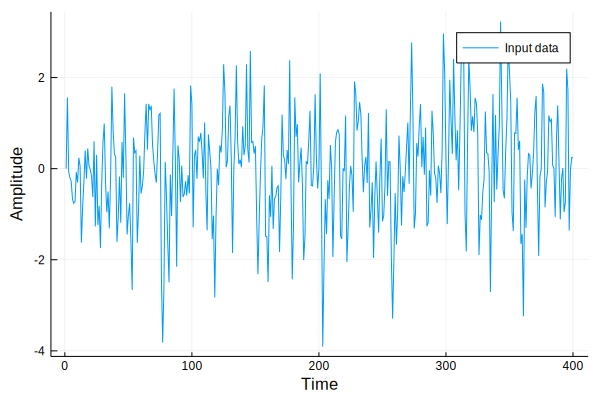

In [234]:
## Plot input data
plt1 = plot(testData, label = "Input data");
xlabel!("Time")
ylabel!("Amplitude")
display(plt1);

In [235]:
## Define p-dimensional statistic
# Sample lag covariance
function sampleLagCovariance(X,k)
    
    n = length(X);
    stepMax = n - k;
    p = k + 1;
    #println("p = " * string(p))
    
    Xmean = mean(X[1:stepMax]);
    Xdemean = X .- Xmean;
    
    runcalc = 0;
    for j in 1:stepMax
        runcalc = runcalc + Xdemean[j+k]*Xdemean[j];
    end
    gammaN = runcalc/stepMax;
    
    return gammaN
end;

In [236]:
lags = 100;
lagN = Array{Any}(undef,lags);
covarianceArray = Array{Any}(undef,lags);
for ii in 1:lags
    lagN[ii] = ii-1;
    covarianceArray[ii] = sampleLagCovariance(testData,ii-1);
end

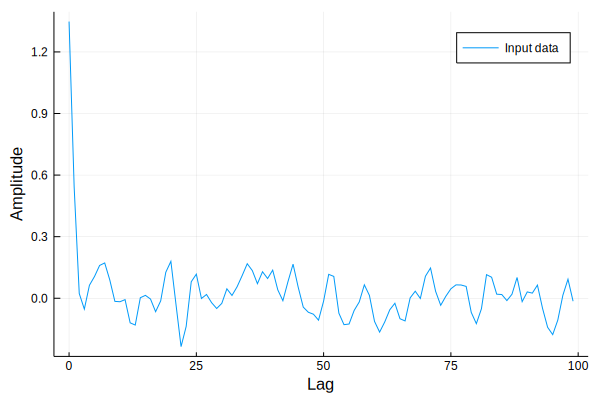

In [237]:
## Plot correlation data
plt2 = plot(lagN, covarianceArray, label = "Input data");
xlabel!("Lag")
ylabel!("Amplitude")
display(plt2);

In [238]:
outData = sampleLagCovariance(testData,4)

0.06319004f0

In [239]:
gamma(x) = sampleLagCovariance(x,4);
gamma(testData)

0.06319004f0

In [250]:
## Bootstrap Statistic
# I.e. lag covariance at k = 4
statisticHandle = gamma;
bootstrapSampleHandle = MBBsample;
#blockLength = 1;
#Nblocks = 400;
blockLength = 100;
Nblocks = 4;
NbootstrapReplicates = 2000;
fullDataEstimate, replicateEstimate, resampleIndexBB, resampleDataBB = bootstrapStatistic(testData, statisticHandle, bootstrapSampleHandle, blockLength, Nblocks, NbootstrapReplicates);
stdStatistic = std(replicateEstimate)

0.049039535f0

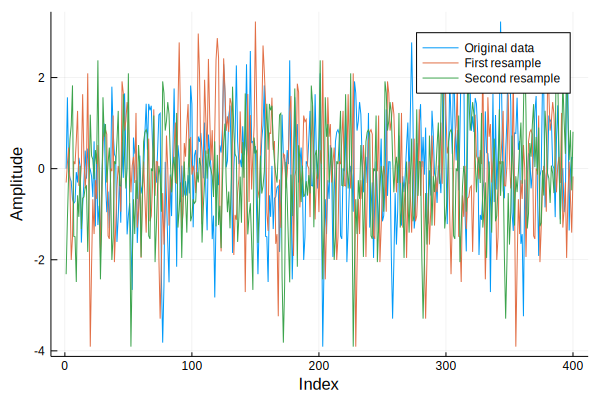

In [251]:
## Plot resampled data
plt3 = plot(testData, label = "Original data");
plot!(resampleDataBB[1], label = "First resample");
plot!(resampleDataBB[2], label = "Second resample");
xlabel!("Index")
ylabel!("Amplitude")
display(plt3);

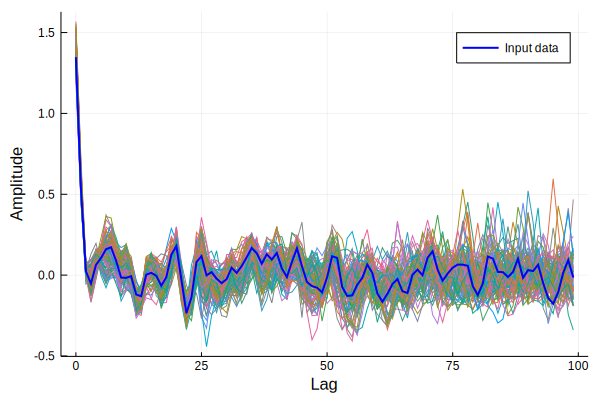

In [252]:
## Bootstrapped acfs
function corrr(inData,lags)
    lagN = Array{Any}(undef,lags);
    covarianceArrayBB = Array{Any}(undef,lags);
    for ii in 1:lags
        lagN[ii] = ii-1;
        covarianceArrayBB[ii] = sampleLagCovariance(inData,ii-1);
    end
    return covarianceArrayBB
end

covarianceArrayBBN = Array{Any}(undef,lags);
for ii in 1:100
    covarianceArrayBBN[ii] = corrr(resampleDataBB[ii],100);
end

## Plot correlation data
plt2 = plot(lagN, covarianceArrayBBN[1], label = "");
for ii in 2:100
    plot!(lagN, covarianceArrayBBN[ii], label = "");
end
plot!(lagN, covarianceArray, label = "Input data", color = :blue, lw=2);
#plot!(lagN, covarianceArrayBBN[1], label = "First resample");
#plot!(lagN, covarianceArrayBBN[2], label = "Second resample");
xlabel!("Lag")
ylabel!("Amplitude")
display(plt2);

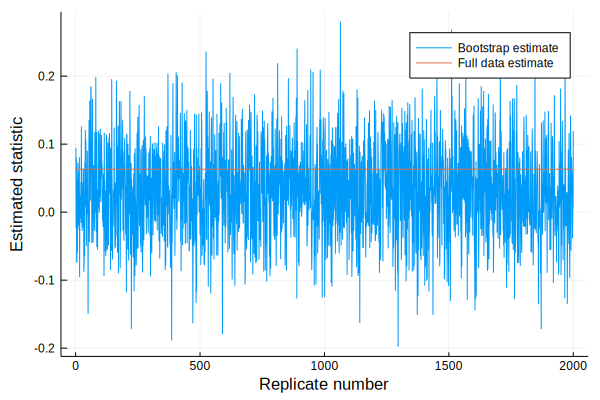

In [243]:
## Plot statistics results
plt4 = plot(replicateEstimate, label = "Bootstrap estimate");
plot!(fullDataEstimate*ones(size(replicateEstimate)), label = "Full data estimate");
xlabel!("Replicate number")
ylabel!("Estimated statistic")
display(plt4);

In [244]:
## Loop over all lags
function oneLag(k,blockLength,Nblocks,NbootstrapReplicates)
    gammaK(x) = sampleLagCovariance(x,k);
    statisticHandle = gammaK;
    bootstrapSampleHandle = MBBsample;
    #blockLength = 100;
    #Nblocks = 4;
    #NbootstrapReplicates = 2000;
    fullDataEstimate, replicateEstimate, resampleIndexBB, resampleDataBB = bootstrapStatistic(testData, statisticHandle, bootstrapSampleHandle, blockLength, Nblocks, NbootstrapReplicates);
    stdStatistic = std(replicateEstimate);
    return stdStatistic
end
oneLag(4,100,4,2000)

0.05030009f0

In [245]:
covarianceStdArray = Array{Any}(undef,lags);
for ii in 1:lags
    #covarianceStdArray[ii] = oneLag(ii-1,100,4,2000);
    covarianceStdArray[ii] = oneLag(ii-1,1,400,2000);
end

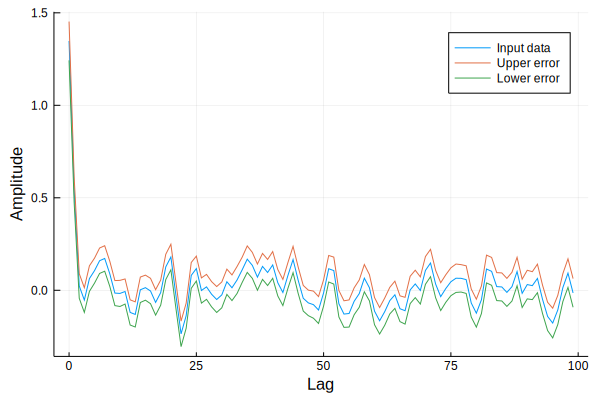

In [246]:
## Plot correlation data
plt5 = plot(lagN, covarianceArray, label = "Input data");
plot!(lagN, covarianceArray .+ covarianceStdArray, label = "Upper error");
plot!(lagN, covarianceArray .- covarianceStdArray, label = "Lower error");
xlabel!("Lag")
ylabel!("Amplitude")
display(plt5);